# Prediction of the function development using RNNs and its comparsion with other NNs

In this work I would like to use various neural network models to predict future price of BTC based on various cryptocurrency prices.  

### Importing libraries

I am going to use tensorflow and other libraries.

In [76]:
# disable gpu
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [77]:
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


## Uncomment w
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [78]:
import glob

In [79]:
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

#### parameters

In [80]:
RATIO_TO_PREDICT = "BTC-USD"
FUTURE_PERIOD_PREDICT = 2

## Loading data

#### Downloaded data
I downloaded dataset from: https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip. It contains 4 separate files with 5 columns for BTC, LTC, ETH and BCH. I am going to use only close price column. Code below extracts mecessary data from those files and creates pandas dataframe from it.

This code loops through ratios and loads the whole file into dataframe. Before adding that dataframe to our main dataframe which is called main_df we will drop unnecessary and only keep close price.

In [81]:
main_df = pd.DataFrame()

ratios = ["BTC-USD", "LTC-USD","ETH-USD","BCH-USD"]

for ratio in ratios:
    dataset = "crypto_data/"+ratio+".csv"
    df = pd.read_csv(dataset, names=["time","low","high","open","close","volume"])
    
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)
    
    df.set_index("time", inplace=True)
    df = df[[f"{ratio}_close"]]
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)


In [82]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97724 entries, 1528968660 to 1535215200
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  97724 non-null  float64
 1   LTC-USD_close  96495 non-null  float64
 2   ETH-USD_close  97422 non-null  float64
 3   BCH-USD_close  87103 non-null  float64
dtypes: float64(4)
memory usage: 6.2 MB


In [83]:
main_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,97724.000000,96495.000000,97422.000000,87103.000000
mean,6773.521546,77.699971,424.308210,723.205108
std,641.354134,12.689494,75.786805,111.495463
min,5778.109863,49.560001,251.000000,473.209991
25%,6341.470215,74.010002,407.059998,686.750000
50%,6536.375000,80.680000,451.450012,742.380005
75%,7286.490112,84.730003,472.070007,810.404999
max,8482.799805,103.040001,547.000000,927.000000


Because there are some NaN values we will get rid of them using code below.

In [84]:
main_df = main_df.dropna()

Here we can see how main_df. It contains 5 columns from which we will be using only close prices.

In [85]:
main_df

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
time,,,,
1528968720,6487.379883,96.660004,486.010010,870.859985
1528968780,6479.410156,96.570000,486.000000,870.099976
1528968840,6479.410156,96.500000,485.750000,870.789978
1528968900,6479.979980,96.389999,486.000000,870.000000
1528968960,6480.000000,96.519997,486.000000,869.989990
...,...,...,...,...
1535214960,6713.140137,58.020000,279.359985,531.479980
1535215020,6714.520020,58.009998,279.359985,531.479980
1535215080,6714.520020,58.020000,279.369995,531.469971


In [86]:
main_df.index = pd.to_datetime(main_df.index,unit='s')

In [87]:
main_df

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
time,,,,
2018-06-14 09:32:00,6487.379883,96.660004,486.010010,870.859985
2018-06-14 09:33:00,6479.410156,96.570000,486.000000,870.099976
2018-06-14 09:34:00,6479.410156,96.500000,485.750000,870.789978
2018-06-14 09:35:00,6479.979980,96.389999,486.000000,870.000000
2018-06-14 09:36:00,6480.000000,96.519997,486.000000,869.989990
...,...,...,...,...
2018-08-25 16:36:00,6713.140137,58.020000,279.359985,531.479980
2018-08-25 16:37:00,6714.520020,58.009998,279.359985,531.479980
2018-08-25 16:38:00,6714.520020,58.020000,279.369995,531.469971


To have better idea what our main dataframe represents we can plot our 4 prices using matplotlib

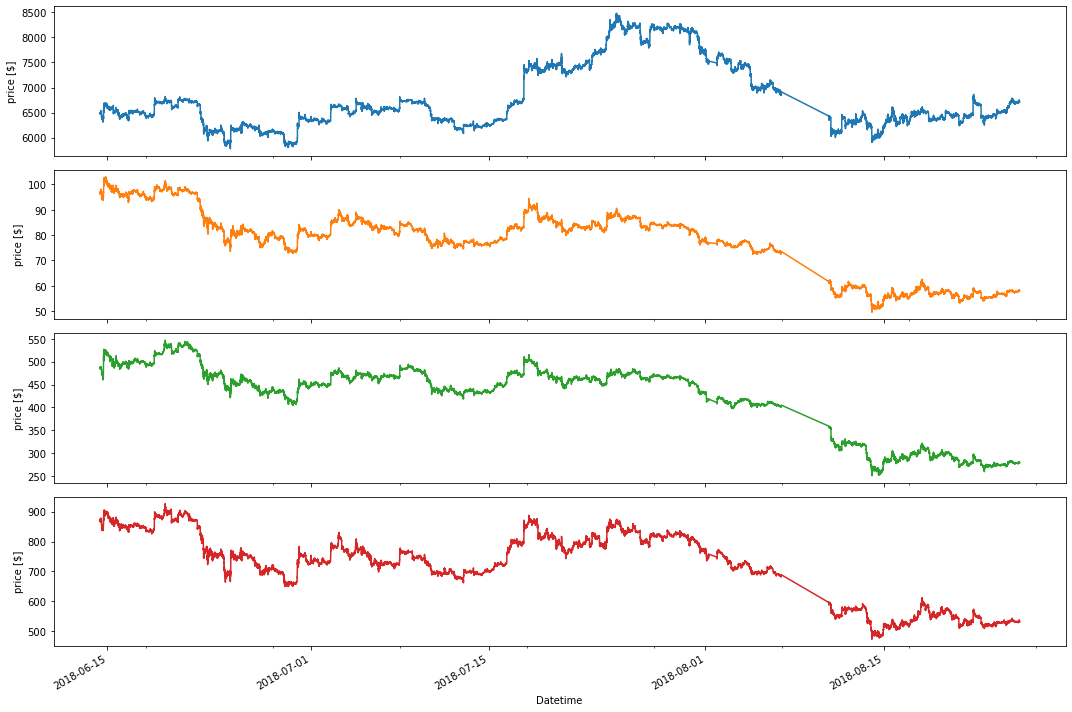

In [88]:
main_df.plot(subplots=True, legend = False, xlabel="Datetime", ylabel="price [$]")
plt.tight_layout()
plt.show()

As we can see, there is a problematic part in our df in two thirds of the lenght.
I will cut the dataframe to exclude that data.

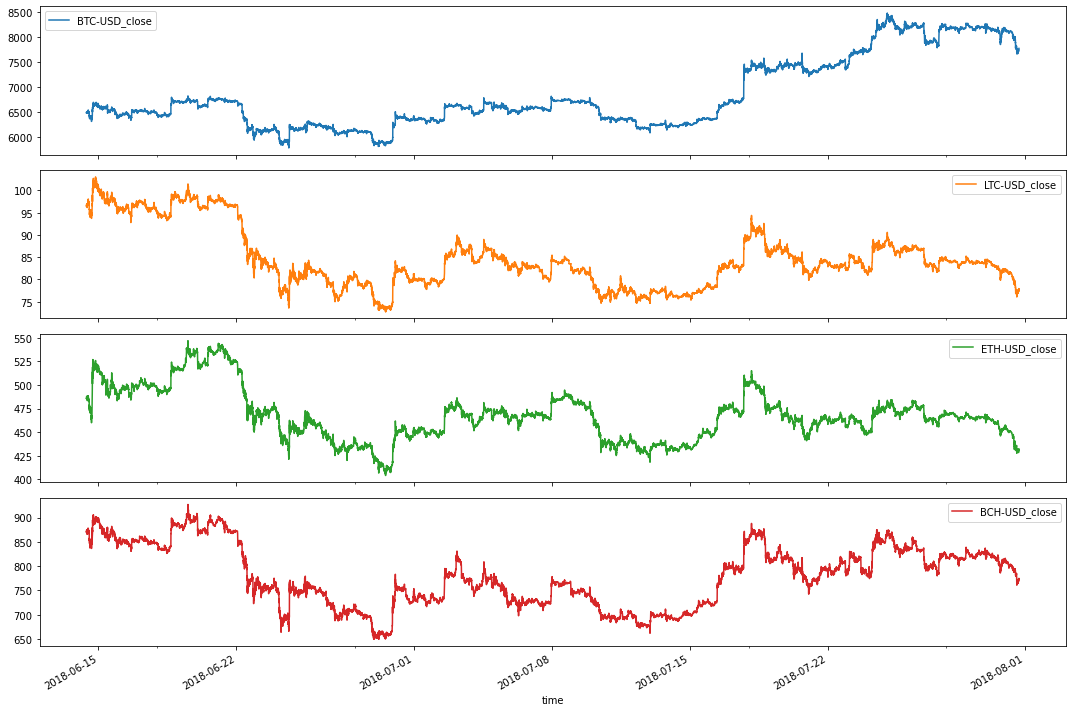

In [89]:
n = int(len(main_df)*0.70)
main_df = main_df[:n]
main_df.plot(subplots=True)
plt.tight_layout()
plt.show()

Another very useful function to use when exploring datasets is describe().

In [90]:
main_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,60281.000000,60281.000000,60281.000000,60281.000000
mean,6820.147480,84.659846,467.844925,780.026503
std,698.026359,6.660242,26.888865,63.047975
min,5778.109863,72.760002,404.220001,649.619995
25%,6330.399902,80.059998,449.600006,726.739990
50%,6591.540039,83.339996,466.250000,777.140015
75%,7374.970215,87.010002,478.700012,831.000000
max,8482.799805,103.040001,547.000000,927.000000


Some more info with .info()

In [91]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60281 entries, 2018-06-14 09:32:00 to 2018-07-31 16:39:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  60281 non-null  float64
 1   LTC-USD_close  60281 non-null  float64
 2   ETH-USD_close  60281 non-null  float64
 3   BCH-USD_close  60281 non-null  float64
dtypes: float64(4)
memory usage: 2.3 MB


#### Created data

This part explores data  I have been collecting.

In [92]:
path = 'crypto_data/my_dataset_csv.csv'               

my_df = pd.read_csv(path, index_col="Datetime", parse_dates=True)  
my_df.fillna(method="ffill", inplace=True)

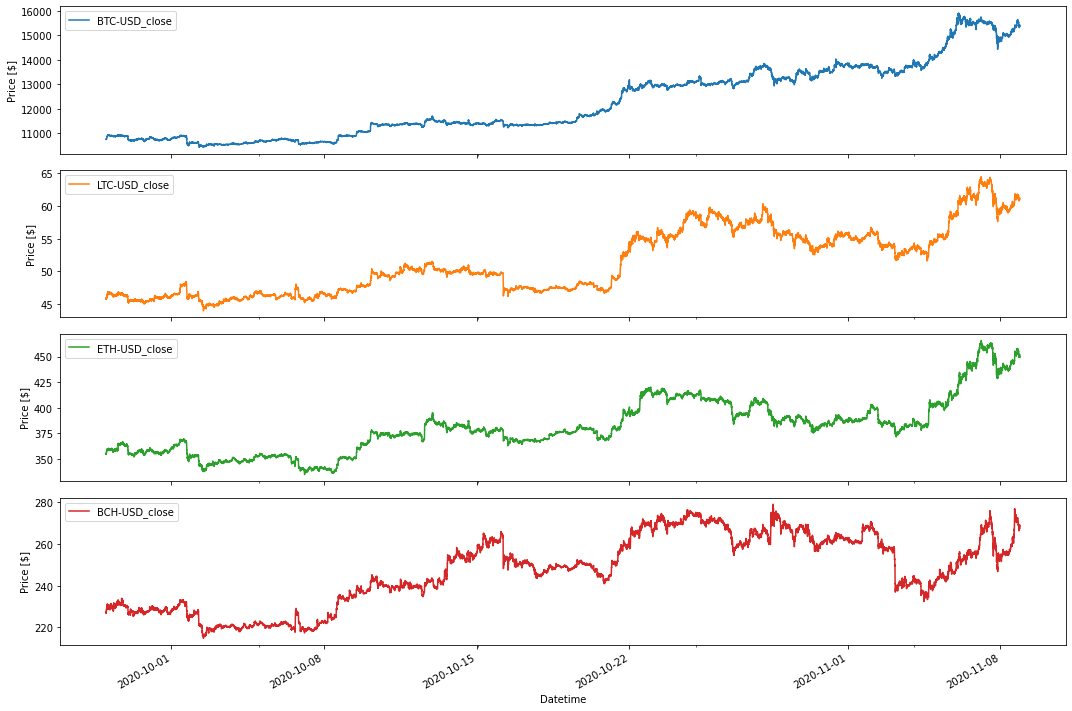

In [94]:
my_df.plot(subplots=True, ylabel="Price [$]")
plt.tight_layout()
plt.show()

In [95]:
#my_df = my_df.drop('Datetime', 1)

In [96]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58393 entries, 2020-09-28 00:00:00+01:00 to 2020-11-08 20:37:00+00:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  58393 non-null  float64
 1   LTC-USD_close  58393 non-null  float64
 2   ETH-USD_close  58393 non-null  float64
 3   BCH-USD_close  58393 non-null  float64
dtypes: float64(4)
memory usage: 2.2+ MB


In [97]:
my_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,58393.000000,58393.000000,58393.000000,58393.000000
mean,12268.990620,51.514071,381.585928,247.550386
std,1457.786256,4.955799,26.543030,16.886831
min,10440.311520,44.019604,334.545563,214.629974
25%,10901.831050,46.996445,363.054962,233.423035
50%,11552.742190,50.106308,379.235748,249.369400
75%,13433.404300,55.417450,394.844269,261.914581
max,15903.437500,64.402084,465.675476,279.121887


#### Convert to percentage change

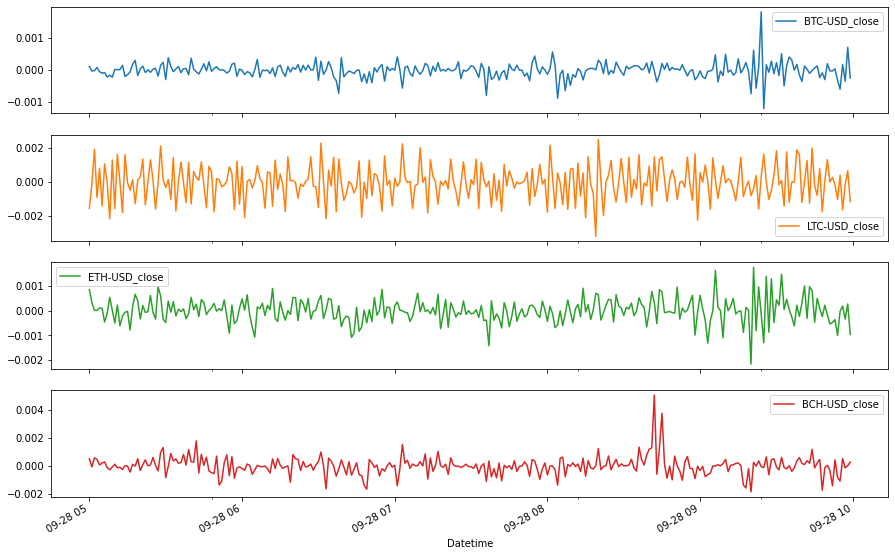

In [98]:
my_df = my_df.pct_change().copy() 
my_df[300:600].plot(subplots=True)
my_df = my_df[1:]
plt.show()

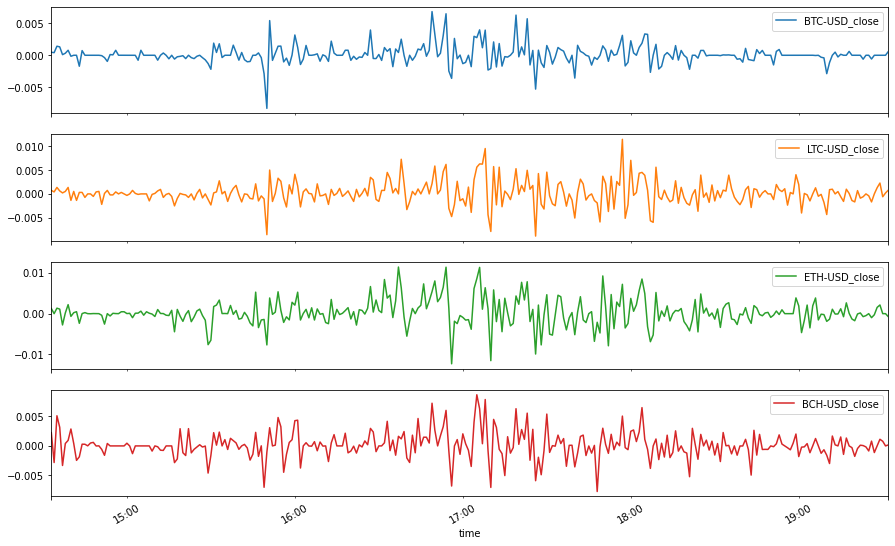

In [100]:
main_df = main_df.pct_change().copy() 
main_df[300:600].plot(subplots=True)
main_df = main_df[1:]
plt.show()

## Splitting data
It is common to split datasets into 3 parts. One is called training set and is uset for training our models. Another part is called validation set and after trainig we evaluate our model using this set and eventually change our model settings. After our model is done we will chceck results on thirs set which is calles test set. This last set is supposed to be uknown for our model so it should behave like "real world" data. We should pick model which does the best job with test set.

I will split main df into 3 parts with this ratio: (70%, 20%, 10%) train, validation, test.

In [101]:
def split_dataset(df):
    
    """
    Function returns train, validation and test dataframes. In ratio 70:20:10.

    Parameters
    ----------
    df: DataFrame
        DataFrame we would like to split

    Returns
    ----------
    Three dataframes.
    """
    
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    return train_df, val_df, test_df

In [102]:
#column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = main_df.shape[1]

In [103]:
train_df_d, val_df_d, test_df_d = split_dataset(main_df)

In [104]:
train_df_my, val_df_my, test_df_my = split_dataset(my_df)

## Normalizing data
Our model could work even without normalizing, but it improves training ability and performance. My data has different scales, for that reason I need to normalize it.

##### Z-score

In [106]:
import joblib
from sklearn.preprocessing import StandardScaler
scaler_d = StandardScaler()  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

train_df_d = pd.DataFrame(scaler_d.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d.transform(test_df_d),columns = test_df_d.columns)


#scaler_my = StandardScaler()
my_scaler_loaded = joblib.load('scalers/scaler_my_pct.gz') # load scaler

train_df_my = pd.DataFrame(my_scaler_loaded.transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(my_scaler_loaded.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(my_scaler_loaded.transform(test_df_my),columns = test_df_my.columns)
""" 
scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)
"""

C:\Users\Admin\anaconda3\envs\nwmGPU\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


' \nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n'

##### Min-max scaler.

In [107]:
"""
from sklearn.preprocessing import MinMaxScaler


scaler_d_min_max = MinMaxScaler()

train_df_d = pd.DataFrame(scaler_d_min_max.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d_min_max.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d_min_max.transform(test_df_d),columns = test_df_d.columns)


scaler_my_min_max = MinMaxScaler()

train_df_my = pd.DataFrame(scaler_my_min_max.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my_min_max.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my_min_max.transform(test_df_my),columns = test_df_my.columns)
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n\n\nscaler_d_min_max = MinMaxScaler()\n\ntrain_df_d = pd.DataFrame(scaler_d_min_max.fit_transform(train_df_d),columns = train_df_d.columns)\nval_df_d = pd.DataFrame(scaler_d_min_max.transform(val_df_d),columns = val_df_d.columns)\ntest_df_d = pd.DataFrame(scaler_d_min_max.transform(test_df_d),columns = test_df_d.columns)\n\n\nscaler_my_min_max = MinMaxScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my_min_max.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my_min_max.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my_min_max.transform(test_df_my),columns = test_df_my.columns)\n'

### Data windowing

Models will make predictions using part of data called windows. 


In [108]:
class WindowGenerator():
    
    """
    Moving window class. Contains needed dataframes for training. 

    Parameters
    ----------
    input_width: int
        Dataframe we would like to split.
        
    input_width: int
        Width of window part model is supposed to predict.
        
    shift: int
        Shift between input and label.
        
    train_df: DataFrame
        Training dataframe
        
    val_df: DataFrame
        Validation dataframe
        
    test_df: DataFrame
        Test dataframe
    
    label_columns: 
        label column indices
    """
    
    
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        # This part takes arguemntes and calculate window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        

        # Window size is equal to input width and shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # slice(0, i_w, None)
        
        # np.arange(5) -> array([0, 1, 2, 3, 4])
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Code below splits data inside window class into inputs and labels.
Inputs are data from which our model is supposed to predict label, 
which is the actual correct value.

In [109]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :] 
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [110]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=2,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d, label_columns=['BTC-USD_close'])
w2


Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [25]
Label column name(s): ['BTC-USD_close']

In [111]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_d[:w2.total_window_size]),
                           np.array(train_df_d[100:100+w2.total_window_size]),
                           np.array(train_df_d[200:200+w2.total_window_size])])


In [112]:

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 26, 4)
Inputs shape: (3, 24, 4)
labels shape: (3, 1, 1)


Simple vizualization of the split window with function plot().

In [113]:
w2.example = example_inputs, example_labels

In [114]:
def plot(self, model=None, plot_col=RATIO_TO_PREDICT+'_close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs) # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-tensorflow
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

In [115]:
def plot_input_data(self,  model=None):
    inputs, labels = self.example
    
    print(inputs)
    plot(inputs)
    
WindowGenerator.plot_input_data = plot_input_data

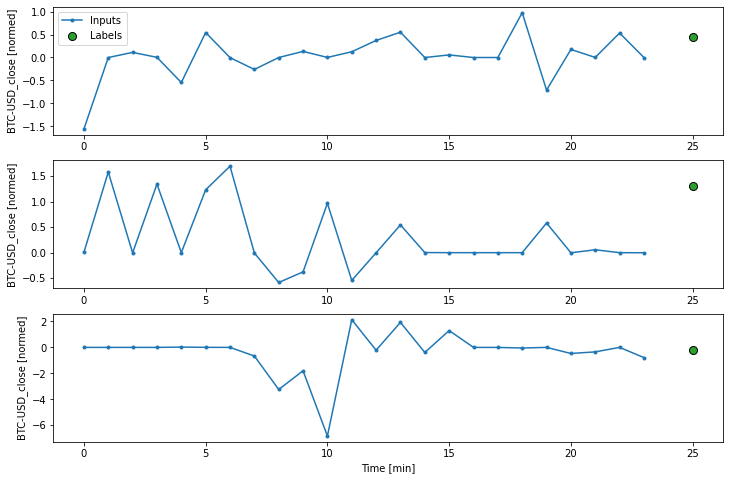

In [116]:
w2.plot()

#### Create dataset

Function below takes dataframe and converts it to tf.data.Dataset with (input_window, label_window) pairs.
First, we convert dataframe to np.array and then timeseries_dataset_from_array function converts it to dataset. 

In [117]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
      # very useful function which converts data to dataset (input_window, label_window) from array

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [118]:
@property  # https://www.python-course.eu/python3_properties.php
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Define wide window

In [119]:
wide_window_d = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

In [120]:
wide_window_my = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=[RATIO_TO_PREDICT+'_close'])

#### To compare prediction performances

In [121]:
val_performance = {}
performance = {}

## Models

MyModel class to make working with models easier. 

In [122]:
from tensorflow.keras.models import load_model

class MyModel():
    
    def __init__(self, model):
        self.model = model
        
    def load_model(self, dir_name):
        self.model = load_model(dir_name)
    
    def eval_mod(self, window, verbose):
        res = self.model.evaluate(window, verbose=verbose)
        print("Loss:", res[0], "MAE:", res[1])
        
    def save_model(self, name):
        self.model.save("models_pct\\models_07_07_2021_1\\"+ name +".model")
        
    def retrain_model(self, window, patience, epochs):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
        history = self.model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
        self.history = history
        
    def compile_and_fit(self, window, patience=3, epochs=120):

        ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=patience,
                                                        mode="min", restore_best_weights=True)
        
        # https://github.com/Jaewan-Yun/optimizer-visualization
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model
        opt = tf.optimizers.Adam(learning_rate=0.5)
        
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=opt,
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = self.model.fit(window.train, epochs=epochs,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history


In [123]:
""" 
Ftrl(
    learning_rate=0.01, learning_rate_power=-0.5, initial_accumulator_value=0.1,
    l1_regularization_strength=0.02, l2_regularization_strength=0.02,
    name='Ftrl', l2_shrinkage_regularization_strength=0.02, beta=0.5)
"""

" \nFtrl(\n    learning_rate=0.01, learning_rate_power=-0.5, initial_accumulator_value=0.1,\n    l1_regularization_strength=0.02, l2_regularization_strength=0.02,\n    name='Ftrl', l2_shrinkage_regularization_strength=0.02, beta=0.5)\n"

#### Training procedure
Because we will train more models let's create function which compiles and train desired model.

To plot learning process there is a function below.

In [124]:
MAX_EPOCHS = 120

def compile_and_fit(model, window, patience=3):

    ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', restore_best_weights=True)

    # https://github.com/Jaewan-Yun/optimizer-visualization
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model

    
    model.compile(loss=tf.losses.LogCosh(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [125]:
def plot_loss(history, graph_param):
    plt.plot(history.history[str(graph_param)], label=str(graph_param))
    plt.plot(history.history['val_'+ str(graph_param)], label='val_' + str(graph_param))
    plt.xlabel('Epoch')
    plt.ylabel(graph_param)
    plt.legend()
    plt.grid(True)

To save model I created function below.

In [126]:
def save_model(model, name):
    model.save("models_21_03_2021\\"+ name +".model")
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#save
    """
    save(filepath, overwrite=True, include_optimizer=True, save_format=None,signatures=None, options=None)
    """

In [127]:
k

NameError: name 'k' is not defined

### Recurrent neural network (LSTM)

[batch, timesteps, feature] 3D input

In [ ]:
act = "tanh"
recurrent_act = "sigmoid"

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
lstm = MyModel(lstm_model)

In [ ]:
history = lstm.compile_and_fit(wide_window_d)

In [ ]:
val_performance['LSTM'] = lstm.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM'] = lstm.eval_mod(wide_window_d.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window_d.plot(lstm.model)

In [ ]:
lstm.save_model("lstm")

#### Loading model

In [ ]:
lstm.model.summary()

### Recurrent neural network (LSTM - bidirectional)

Parameters from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [ ]:
lstm_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
lstm_bidi = MyModel(lstm_model_bidirectional)

In [ ]:
history = lstm_bidi.compile_and_fit(wide_window_d)

In [ ]:
val_performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window_d.plot(lstm_bidi.model)

In [ ]:
lstm_bidi.save_model("l_bidi")

### Recurrent neural network (GRU)

Parameters from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [ ]:
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(512,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(512,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(512,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])


In [ ]:
gru = MyModel(gru_model)

In [ ]:
history = gru.compile_and_fit(wide_window_d)

In [ ]:
val_performance['GRU'] = gru.eval_mod(wide_window_d.val, verbose=1)
performance['GRU'] = gru.eval_mod(wide_window_d.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window_d.plot(gru.model)

In [ ]:
gru.save_model("gru")

### Recurrent neural network (GRU - bidirectional)

In [ ]:
gru_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
gru_bidi = MyModel(gru_model_bidirectional)

In [ ]:
history = gru_bidi.compile_and_fit(wide_window_d)

In [ ]:
val_performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window_d.plot(gru_bidi.model)

In [ ]:
gru_bidi.save_model("g_bidi")

### Performance

In [ ]:
"""
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


plt.ylabel('mean_absolute_error [BTC-USD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
"""

In [ ]:
"""
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')
"""

## Single shot models
The entire sequence prediction in a single step.

24 min to the future with 2 min to the future

In [148]:
OUT_STEPS = 1
wide_window_d_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

wide_window_my_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=[RATIO_TO_PREDICT+'_close'])



In [ ]:
wide_window_my_single.plot()

In [ ]:
single_val_performance = {}
single_performance = {}

### LSTM single shot

In [ ]:
lstm_model_single = tf.keras.Sequential([
    
    tf.keras.layers.LSTM(512,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(512,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(512, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [ ]:
lstm_single = MyModel(lstm_model_single)

In [ ]:
history = lstm_single.compile_and_fit(wide_window_d_single)

In [ ]:
single_val_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
lstm_single.save_model("lstm_s")

### LSTM Bidirectional single shot

In [ ]:
lstm_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
lstm_bidi_single = MyModel(lstm_model_bidirectional_single)

In [ ]:
history = lstm_bidi_single.compile_and_fit(wide_window_d_single)

In [ ]:
single_val_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
lstm_bidi_single.save_model("l_b_s")

### GRU single shot

In [ ]:
gru_model_single = tf.keras.models.Sequential([

    tf.keras.layers.GRU(512,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(512,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(512, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [ ]:
gru_single = MyModel(gru_model_single)

In [ ]:
history = gru_single.compile_and_fit(wide_window_d_single)

In [ ]:
single_val_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
gru_single.save_model("gru_s")

### GRU Bidirectional single shot

In [ ]:
gru_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(64, activation=act),
    tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
gru_bidi_single = MyModel(gru_model_bidirectional_single)

In [ ]:
history = gru_bidi_single.compile_and_fit(wide_window_d_single)

In [ ]:
single_val_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
gru_bidi_single.save_model("g_b_s")

### Evaluating loaded models

In [ ]:
model.summary()

In [554]:
path = "models_10_04_2021"

In [555]:
lstm = load_model("models_pct/"+path+"/lstm.model")
lstm_bidi = load_model("models_pct/"+path+"/l_bidi.model")
gru = load_model("models_pct/"+path+"/gru.model")
gru_bidi = load_model("models_pct/"+path+"/g_bidi.model")

## Single shot 
lstm_s = load_model("models_pct/"+path+"/lstm_s.model")
lstm_bidi_s = load_model("models_pct/"+path+"/l_b_s.model")
gru_s = load_model("models_pct/"+path+"/gru_s.model")
gru_bidi_s = load_model("models_pct/"+path+"/g_b_s.model")

In [556]:
loaded_model_lstm = MyModel(lstm)

In [557]:
loaded_model_lstm.eval_mod(wide_window_d.val, 0)

Loss: 1.3045247793197632 MAE: 0.5783761739730835


In [558]:
loaded_model_lstm.eval_mod(wide_window_d.test, 0)

Loss: 0.9792885184288025 MAE: 0.4470216929912567


In [559]:
loaded_model_lstm.eval_mod(wide_window_my.test, 0)

Loss: 2.57881498336792 MAE: 0.7174023985862732


In [560]:
loaded_model_lstm_b = MyModel(lstm_bidi)

In [561]:
loaded_model_lstm_b.eval_mod(wide_window_d.val, 0)

Loss: 0.11057772487401962 MAE: 0.0697709172964096


In [562]:
loaded_model_lstm_b.eval_mod(wide_window_d.test, 0)

Loss: 0.08315346390008926 MAE: 0.05674205720424652


In [563]:
loaded_model_lstm_b.eval_mod(wide_window_my.test, 0)

Loss: 0.22071212530136108 MAE: 0.09320876002311707


In [564]:
loaded_model_gru = MyModel(gru)

In [565]:
loaded_model_gru.eval_mod(wide_window_d.val, 0)

Loss: 1.3363330364227295 MAE: 0.5927208662033081


In [566]:
loaded_model_gru.eval_mod(wide_window_d.test, 0)

Loss: 0.9828724265098572 MAE: 0.45859307050704956


In [567]:
loaded_model_gru.eval_mod(wide_window_my.test, 0)

Loss: 2.700249195098877 MAE: 0.7778339385986328


In [568]:
loaded_model_gru_bidi = MyModel(gru_bidi)

In [569]:
loaded_model_gru_bidi.eval_mod(wide_window_d.val, 0)

Loss: 0.11264970153570175 MAE: 0.07513885945081711


In [570]:
loaded_model_gru_bidi.eval_mod(wide_window_d.test, 0)

Loss: 0.08411668986082077 MAE: 0.06192982941865921


In [571]:
loaded_model_gru_bidi.eval_mod(wide_window_my.test, 0)

Loss: 0.22588711977005005 MAE: 0.10365895926952362


#### Eval single

In [572]:
loaded_model_lstm_s = MyModel(lstm_s)

In [573]:
loaded_model_lstm_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2931909561157227 MAE: 0.5700112581253052


In [574]:
loaded_model_lstm_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9794927835464478 MAE: 0.4381137490272522


In [575]:
loaded_model_lstm_s.eval_mod(wide_window_my_single.test, 0)

Loss: 2.5699710845947266 MAE: 0.6956222057342529


In [576]:
lstm_s.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 24, 256)           267264    
_________________________________________________________________
lstm_29 (LSTM)               (None, 24, 256)           525312    
_________________________________________________________________
lstm_30 (LSTM)               (None, 24, 256)           525312    
_________________________________________________________________
lstm_31 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_30 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 1,851,457
Trainable params: 1,851,457
Non-trainable params: 0
___________________________________________

In [577]:
loaded_model_lstm_b_s = MyModel(lstm_bidi_s)

In [578]:
loaded_model_lstm_b_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2988550662994385 MAE: 0.5809773802757263


In [579]:
loaded_model_lstm_b_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9823020696640015 MAE: 0.4524049758911133


In [580]:
loaded_model_lstm_b_s.eval_mod(wide_window_my_single.test, 0)

Loss: 2.578188896179199 MAE: 0.7179375886917114


In [581]:
loaded_model_gru_s = MyModel(gru_s)

In [582]:
loaded_model_gru_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2975988388061523 MAE: 0.5783743262290955


In [583]:
loaded_model_gru_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9821787476539612 MAE: 0.44889768958091736


In [584]:
loaded_model_gru_s.eval_mod(wide_window_my_single.test, 0)

Loss: 2.5810959339141846 MAE: 0.717247724533081


In [585]:
loaded_model_gru_b_s = MyModel(gru_bidi_s)

In [586]:
loaded_model_gru_b_s.eval_mod(wide_window_d_single.val, 0)

Loss: 1.2919645309448242 MAE: 0.5726442337036133


In [587]:
loaded_model_gru_b_s.eval_mod(wide_window_d_single.test, 0)

Loss: 0.9792340397834778 MAE: 0.4429818093776703


In [588]:
loaded_model_gru_b_s.eval_mod(wide_window_my_single.test, 0)

Loss: 2.569202423095703 MAE: 0.701622724533081
